In [1]:
import os, sys
sys.path.append('/workspaces/python-trend-labeller')

In [2]:
import pandas as pd

from src.visualization.utils import plot_trend_labels
from src.returns_estimation import ReturnsEstimatorWithFees
from src.optimization import Optimizer
from src.returns_estimation.fees_config import FeesConfig
from src.trend_labelling import BinaryCTL

Let's import the data. We will use only the closing prices for our time series.

In [3]:
df_list = []
for file in os.listdir('/workspaces/python-trend-labeller/notebooks/data'):
    if file.endswith('.parquet'):
        df_list.append(pd.read_parquet(f'/workspaces/python-trend-labeller/notebooks/data/{file}'))


In [4]:
df_concat = pd.concat(df_list).sort_values(by='t')
df_concat.drop_duplicates(subset='t', keep='first', inplace=True)

# Using a labeller

We can now instantiate a binary parametrized labeller.

Uptrend periods: 6524, Downtrend periods: 5389


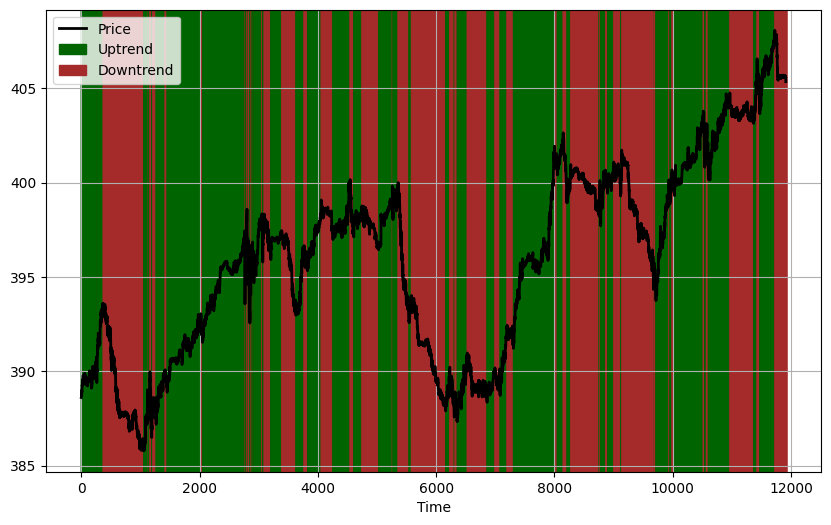

In [5]:
from collections import Counter
from itertools import chain


concatenated_closing_prices = df_concat.c.to_list()

binary_labeller = BinaryCTL(omega=0.003)
labels = binary_labeller.get_labels(concatenated_closing_prices)
print(f"Uptrend periods: {Counter(labels)[1]}, Downtrend periods: {Counter(labels)[-1]}")
plot_trend_labels(concatenated_closing_prices, labels)


# Finding a good set of parameters for the labeller

All the labellers entirely rely on the parametrization that govern their algorithm. One direct way to find a good set of parameters is by applying Bayesian optimization to the cumulative returns of the labeller, defined as the total net downtrend and uptrend variation correctly labelled.

Let's for instance consider a simple return estimator without fees.

In [ ]:
from src.returns_estimation.returns_estimation import SimpleReturnEstimator

# Let's instantiate the optimizer with a simple return estimator without fees. We will use 10 initial points and 30 iterations for our bayesian optimization.
opt = Optimizer(SimpleReturnEstimator(), initial_points=10, nb_iter=30)

Bayesian optimization is bounded so we need to define the bounds of the parameters. If not specified it will use the default available in src.optimization.optimization_bounds.
We can specify a custom range as well. 
We can also specify the acquisition function. Here we use the upper confidence bound.

In [10]:
custom_bounds = {
    "omega": (0, 0.1),
}
optimization_results = opt.optimize(BinaryCTL, concatenated_closing_prices, custom_bounds, verbose=1)

|   iter    |  target   |   omega   |
-------------------------------------
| 5         | 16.74     | 0.03095   |
| 6         | 60.16     | 0.01942   |
| 9         | 106.6     | 0.009924  |
| 11        | 194.3     | 0.004199  |
| 12        | 1.072e+03 | 2.218e-06 |


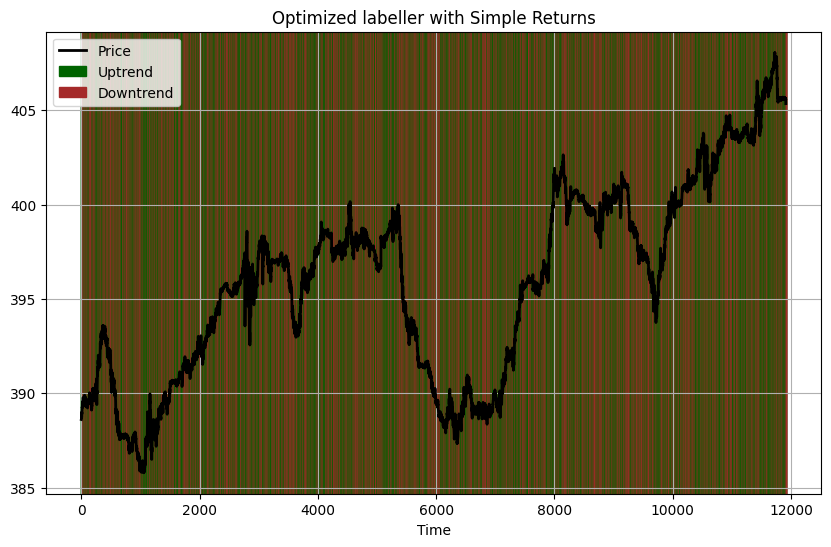

In [11]:
labeller = BinaryCTL(**optimization_results['params'])
labels = labeller.get_labels(concatenated_closing_prices)
plot_trend_labels(concatenated_closing_prices, labels, title="Optimized labeller with Simple Returns")

For noisy signals like the one above, simply maximizing the returns leads to trend labeller parametrizations that identify very atomic trends. Let's see how we can deal with this.

# Advanced return estimation

The use of the simple return estimator can easily lead to overfitted labels with some labeller classes. To overcome this issue, we can use more advanced return estimators penalising label changes or holding a position .

In [15]:
from src.returns_estimation.returns_estimation import ReturnsEstimatorWithFees

fees_config = FeesConfig(
    lp_transaction_fees=0.01, # Higher fees discourage frequent label changes
    sp_transaction_fees=0.01
)
# Let's repeat the optimization with the new return estimator.
opt = Optimizer(ReturnsEstimatorWithFees(fees_config), initial_points=10, nb_iter=80)
optimization_results = opt.optimize(BinaryCTL, concatenated_closing_prices, custom_bounds, verbose=1)



|   iter    |  target   |   omega   |
-------------------------------------
| 5         | 12.85     | 0.04072   |
| 6         | 30.62     | 0.02602   |
| 10        | 55.25     | 0.01151   |


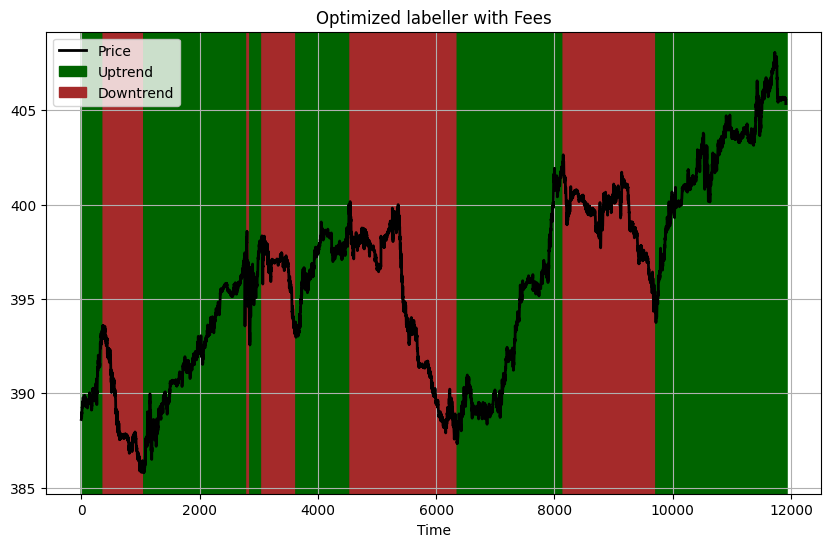

In [16]:
labeller = BinaryCTL(**optimization_results['params'])
labels = labeller.get_labels(concatenated_closing_prices)
plot_trend_labels(concatenated_closing_prices, labels, title="Optimized labeller with Fees")

The FeesConfig class also allows to prioritise one position over the other. Let's for example increase the fees for the short position.


In [14]:
fees_config = FeesConfig(
    lp_transaction_fees=0.002,
    sp_transaction_fees=0.04,
)
opt = Optimizer(ReturnsEstimatorWithFees(fees_config), initial_points=10, nb_iter=50)
opt.optimize(BinaryCTL, concatenated_closing_prices, custom_bounds, verbose=1)


labeller = BinaryCTL(**optimization_results['params'])
labels = labeller.get_labels(concatenated_closing_prices)

|   iter    |  target   |   omega   |
-------------------------------------
| 5         | 15.96     | 0.04835   |
| 9         | 24.83     | 0.02501   |
| 15        | 25.72     | 0.01754   |


We see that the algorithm get more picky when labelling downward trends.

In [73]:
Counter(labels)

Counter({1: 8534, -1: 3379})

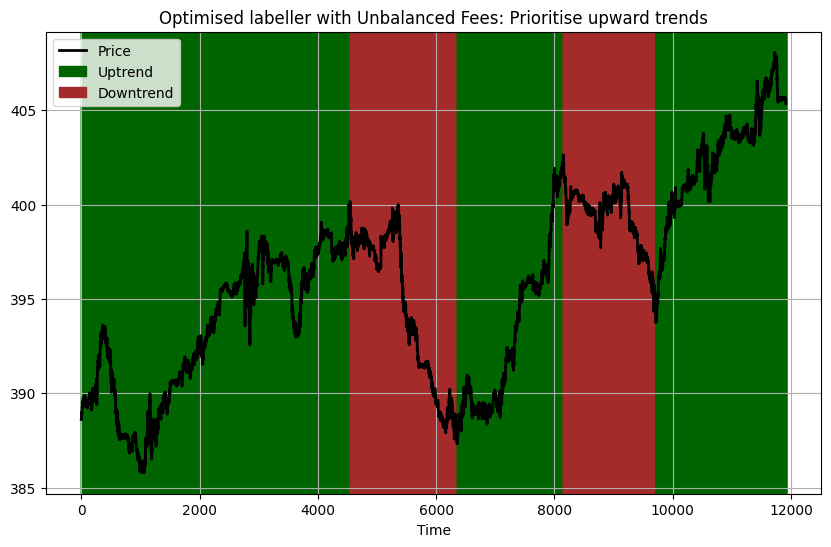

In [74]:
labeller = BinaryCTL(**optimization_results['params'])
labels = labeller.get_labels(concatenated_closing_prices)
plot_trend_labels(concatenated_closing_prices, labels, title="Optimized labeller with Unbalanced Fees: Prioritise upward trends")

The idea behind the fees paradigm is to help you choose a parametrization for your labeller that can generalise to similar time series (time series of similar period, for instance) .